## Part 3 - Generating Final Dictionaries, Visualizations and Computing Similarities 

#### Imports

In [2]:
import pickle
import pandas as pd
import numpy as np

# Graphs 
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re

# Wordcloud
from wordcloud import WordCloud
import random


from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from collections import Counter
import scipy.sparse

### Question 6 - Generating Dictionary Tables

#### Loading the files and preparing the genres

In [3]:
# Load the pickle file
with open('top30_by_genre.pkl', 'rb') as f:
    genre_dict_raw = pickle.load(f)
genre_dict_raw

{'fiction': honour        0.007794
 color         0.007642
 car           0.007621
 nodded        0.007591
 honor         0.007464
 dr            0.007406
 stared        0.007374
 maybe         0.007320
 colour        0.007310
 paused        0.007256
 dollar        0.007214
 said mr       0.007212
 aunt          0.007170
 shook head    0.007115
 poet          0.007080
 hotel         0.007035
 priest        0.006955
 job           0.006944
 glanced       0.006913
 grey          0.006864
 paris         0.006847
 mary          0.006792
 palace        0.006738
 staring       0.006715
 lad           0.006690
 cousin        0.006623
 mistress      0.006615
 tiny          0.006589
 lake          0.006582
 kissed        0.006579
 dtype: float64,
 'classics': honour        0.008814
 colour        0.008111
 poet          0.007868
 aunt          0.007635
 honor         0.007393
 said mr       0.007332
 priest        0.007321
 mistress      0.007299
 grey          0.007287
 paused        0.007262


#### 
We decided to focus on the following genres 
1. Romance 
2. Adventure 
3. Biography 
4. Fantasy 
5. Politics 
6. Philosopy 
7. Religion

The main reason for this is because other genres are too broad and it would be difficult to tell which genre a term belongs to. A genre like fiction will encompass such a large variety of terms that it will not be distintinctive enough for this analysis. 

We want to display the top 30 terms their by TF-IDF weightings scores for each of these genres side by side. The intuition we have is that the terms in these dictionaries should be clear indicators of their genre. We should be able to tell what genre a term belongs to by looking at the top 30 terms appearing in this dictionary. 

In [4]:
# List the genres to compare 
desired_genres = ['romance', 'adventure', 'biography', 'fantasy', 'politics', 'philosophy', 'religion']

# For each desired genre, extract the top 10 terms (by aggregated TF-IDF score)
top_terms = {}
for genre in desired_genres:
    # Check if the genre exists in the dictionary 
    if genre in genre_dict_raw:
        # Sort the terms by score descending
        sorted_terms = sorted(genre_dict_raw[genre].items(), key=lambda x: x[1], reverse=True)
        # Get the top 30 terms (just the term names, ignoring scores)
        top_terms[genre] = [term for term, score in sorted_terms[:30]]
    else:
        top_terms[genre] = []

# Pad the lists so they are all the same length (for display purposes)
max_len = max(len(lst) for lst in top_terms.values())
for genre in top_terms:
    if len(top_terms[genre]) < max_len:
        top_terms[genre].extend([None] * (max_len - len(top_terms[genre])))

# Create a df with genres as columns and rows as the rank (1st term, 2nd term, etc.)
df_top_terms = pd.DataFrame(top_terms)
df_top_terms.index = [f"Rank {i+1}" for i in range(max_len)]

print(df_top_terms)

# Convert to a LaTeX table 
latex_table = df_top_terms.to_latex(index=True, na_rep='', caption="Top 30 Terms by Genre", label="tab:top_terms", float_format="%.3f")

# Ask gpt to format this in a beautiful way
print(latex_table)


            romance   adventure   biography     fantasy        politics  \
Rank 1       kissed      nodded     william      nodded       political   
Rank 2       madame      stared          dr      stared         citizen   
Rank 3     mistress       cabin     british      palace        national   
Rank 4       honour  shook head       troop       maybe    constitution   
Rank 5         aunt      paused       henry       giant    united state   
Rank 6        paris        deck   political      paused       president   
Rank 7       paused     glanced      german  shook head        military   
Rank 8       nodded         lad    national        cave        republic   
Rank 9      glanced       swung   president       magic      revolution   
Rank 10      stared        crew       paris        grey           union   
Rank 11     said mr        rode     charles        tiny     institution   
Rank 12  shook head       cliff    military     glanced            vote   
Rank 13      cousin      

We load our original generated DTM with TF-IDF weights. 

In [5]:
# Load DTM 
print("Loading DTM...")
df_dtm = pd.read_csv('dtm_with_genres.csv', index_col=0)

# Convert genres from strings to lists if needed
if df_dtm['genres'].dtype == object:
    print("Converting genres to proper format...")
    df_dtm['genres'] = df_dtm['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


Loading DTM...
Converting genres to proper format...


We convert our dictionaries into a dictionary of dictionaries (each genre gets its own dictionary for words and their frequencies).

In [6]:
# Parse the genre dictionary to extract words and scores
def parse_genre_dict(genre_dict_raw):
    parsed_dict = {}
    for genre, content in genre_dict_raw.items():
        word_scores = content.to_dict()
        parsed_dict[genre] = word_scores
    return parsed_dict

# Parse the dictionaries to create the dict of dicts
genre_dict = parse_genre_dict(genre_dict_raw)
print(genre_dict)

{'fiction': {'honour': 0.0077935937959340805, 'color': 0.0076419902800118076, 'car': 0.007620964398895259, 'nodded': 0.0075912803181544895, 'honor': 0.007463748678161048, 'dr': 0.007406017258594644, 'stared': 0.0073743595956406475, 'maybe': 0.007320115611277029, 'colour': 0.007310036481723138, 'paused': 0.007256293759157821, 'dollar': 0.007214461263876124, 'said mr': 0.007211944221583573, 'aunt': 0.007169921717486648, 'shook head': 0.007115128447955773, 'poet': 0.007080240122047319, 'hotel': 0.007034515095124469, 'priest': 0.006954853626333904, 'job': 0.006943644463513623, 'glanced': 0.006913147557841147, 'grey': 0.0068637098083411474, 'paris': 0.006846586242776095, 'mary': 0.006792393187600905, 'palace': 0.006738486534911912, 'staring': 0.006714655450382811, 'lad': 0.006689728583835931, 'cousin': 0.006622845315626286, 'mistress': 0.006614754794750075, 'tiny': 0.006589289875164916, 'lake': 0.006582270880404213, 'kissed': 0.006578658487075049}, 'classics': {'honour': 0.00881444073782917

Below is just a re-iteration of the point we were making. Our corpus consists of around 9000 books, and already 6244 of these are classified as fiction. We want to be able to identify the more specific genres. 

In [7]:
# Get all available genres from the dictionaries
available_genres = list(genre_dict.keys())
print(f"Available genres with dictionaries: {available_genres}")

all_genres = []
for genres_list in df_dtm['genres']:
    if isinstance(genres_list, list):
        all_genres.extend([g for g in genres_list if g in available_genres])

genre_counts = Counter(all_genres)
print("Overall genre counts (top 15):")
for genre, count in genre_counts.most_common(15):
    print(f"  {genre}: {count}")

Available genres with dictionaries: ['fiction', 'classics', 'historical', 'non-fiction', '20th-century', 'literature', 'historical-fiction', 'novels', 'short-stories', 'romance', 'fantasy', 'american', 'literary-fiction', 'adventure', 'childrens', 'adult', 'biography', 'science-fiction', 'mystery', 'school', 'adult-fiction', 'philosophy', 'young-adult', 'unfinished', 'drama', 'poetry', 'contemporary', 'humor', 'religion', 'politics']
Overall genre counts (top 15):
  fiction: 6244
  classics: 4565
  historical: 3359
  non-fiction: 2655
  20th-century: 2629
  literature: 2267
  historical-fiction: 2233
  novels: 1899
  short-stories: 1751
  romance: 1671
  fantasy: 1162
  american: 1155
  literary-fiction: 1116
  adventure: 1100
  childrens: 1093


## 7.1 
We are going to focus on the 7 genres we defined earlier. 

In [8]:
# Check which of our desired genres have dictionaries
available_desired_genres = [genre for genre in desired_genres if genre in genre_dict]
print(f"\nAvailable dictionaries for desired genres: {available_desired_genres}")

# Calculate genre frequency for our desired genres
print("\nCalculating genre frequency across all books for desired genres...")
desired_genre_counts = {genre: 0 for genre in desired_genres}
for genres_list in df_dtm['genres']:
    if isinstance(genres_list, list):
        for genre in genres_list:
            if genre in desired_genres:
                desired_genre_counts[genre] += 1

# Sort by frequency
sorted_genre_counts = {k: v for k, v in sorted(desired_genre_counts.items(), key=lambda item: item[1], reverse=True)}
print("Genre counts for desired genres:")
for genre, count in sorted_genre_counts.items():
    print(f"  {genre}: {count}")

# Display dictionary content for our desired genres
print("\nDictionary content for desired genres:")
for genre in available_desired_genres:
    word_scores = genre_dict[genre]
    print(f"\n{genre.upper()} DICTIONARY:")
    # Sort by score and format for display
    sorted_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)
    # Format each entry
    formatted = [f"{word}: {score:.6f}" for word, score in sorted_words[:15]]  # Show only top 15 words
    # Display in rows for better readability
    for i in range(0, len(formatted), 3):
        print("  " + "  |  ".join(formatted[i:i+3]))

# ----- Prepare Document and Dictionary Vectors -----
print("\nPreparing document and dictionary vectors...")
# Pre-filter word columns (excluding 'genres' and count columns)
word_cols = [col for col in df_dtm.columns if col != 'genres' and not col.endswith('_count') and not col.endswith('_similarity')]

# Create document vectors 
def create_document_vectors(df, words):
    """Create document vectors for all books based on their TF-IDF weighted words"""
    # Ensure we only use numeric columns
    numeric_cols = []
    for col in words:
        # Skip columns that have non-numeric data
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_cols.append(col)
        else:
            print(f"Warning: Skipping non-numeric column: {col}")
    
    print(f"Using {len(numeric_cols)} numeric columns for document vectors")
    
    # Create vectors using only numeric data
    doc_vectors = df[numeric_cols].copy()
    return doc_vectors, numeric_cols

# Create dictionary vectors
def create_dictionary_vectors(dictionary_words, all_words, desired_genres):
    """Create dictionary vectors for each genre dictionary"""
    dictionary_vectors = {}
    
    for genre in desired_genres:
        if genre not in dictionary_words:
            continue
            
        word_scores = dictionary_words[genre]
        # Initialize vector with zeros
        vector = np.zeros(len(all_words))
        
        # Fill in scores for words that exist in this dictionary
        for i, word in enumerate(all_words):
            if word in word_scores:
                vector[i] = word_scores[word]
        
        dictionary_vectors[genre] = vector
    
    return dictionary_vectors

# Create document and dictionary vectors
print("Creating document vectors...")
doc_vectors, numeric_word_cols = create_document_vectors(df_dtm, word_cols)

print("Creating dictionary vectors for desired genres...")
dict_vectors = create_dictionary_vectors(genre_dict, numeric_word_cols, available_desired_genres)

# ----- Implement Multiple Similarity Methods -----
print("\nImplementing multiple similarity methods...")

# 1. DOT PRODUCT
def calculate_dot_product(doc_vectors, dict_vectors):
    """Calculate dot product between books and dictionaries"""
    similarity_dict = {}
    doc_array = doc_vectors.values
    
    for genre, dict_vector in dict_vectors.items():
        # Reshape dictionary vector to 2D
        dict_array = dict_vector.reshape(1, -1)
        
        # Calculate dot product (use matrix multiplication)
        dot_products = np.dot(doc_array, dict_array.T).flatten()
        
        # Store in dictionary
        similarity_dict[f"{genre}_dot"] = dot_products
    
    return pd.DataFrame(similarity_dict, index=doc_vectors.index)

# 2. COSINE SIMILARITY
def calculate_cosine_similarities(doc_vectors, dict_vectors):
    """Calculate cosine similarity between books and dictionaries"""
    similarity_dict = {}
    doc_array = doc_vectors.values
    
    for genre, dict_vector in dict_vectors.items():
        # Reshape dictionary vector to 2D
        dict_array = dict_vector.reshape(1, -1)
        
        # Calculate cosine similarity
        similarities = cosine_similarity(doc_array, dict_array).flatten()
        
        # Store in dictionary
        similarity_dict[f"{genre}_cosine"] = similarities
    
    return pd.DataFrame(similarity_dict, index=doc_vectors.index)

# 3. JENSEN-SHANNON DIVERGENCE
def calculate_js_divergence(doc_vectors, dict_vectors):
    """Calculate Jensen-Shannon divergence between books and dictionaries"""
    similarity_dict = {}
    doc_array = doc_vectors.values
    
    # Normalize the document vectors for probability distribution
    doc_array_norm = np.copy(doc_array)
    row_sums = doc_array_norm.sum(axis=1)
    # Avoid division by zero
    row_sums[row_sums == 0] = 1
    doc_array_norm = doc_array_norm / row_sums[:, np.newaxis]
    
    for genre, dict_vector in dict_vectors.items():
        # Normalize dictionary vector for probability distribution
        dict_vector_norm = dict_vector / (dict_vector.sum() or 1)  # Avoid division by zero
        
        # Calculate JS divergence for each document
        js_divs = np.zeros(len(doc_vectors))
        
        for i, doc in enumerate(doc_array_norm):
            # Only calculate if the document has non-zero values
            if np.sum(doc) > 0:
                # Calculate JS divergence (lower is more similar)
                js_div = jensenshannon(doc, dict_vector_norm)
                
                # Sometimes JS distance returns NaN if distributions have different zeros
                if np.isnan(js_div):
                    js_div = 1.0  # Maximum distance
                
                # Convert to similarity (1 - distance) so higher is more similar
                js_divs[i] = 1.0 - js_div
            else:
                js_divs[i] = 0
        
        # Store in dictionary
        similarity_dict[f"{genre}_js"] = js_divs
    
    return pd.DataFrame(similarity_dict, index=doc_vectors.index)

# Calculate similarity scores using all three methods
print("Calculating dot product scores...")
dot_product_df = calculate_dot_product(doc_vectors, dict_vectors)

print("Calculating cosine similarity scores...")
cosine_df = calculate_cosine_similarities(doc_vectors, dict_vectors)

print("Calculating Jensen-Shannon divergence scores...")
js_df = calculate_js_divergence(doc_vectors, dict_vectors)

# Add scores to the main DataFrame
for col in dot_product_df.columns:
    df_dtm[col] = dot_product_df[col]

for col in cosine_df.columns:
    df_dtm[col] = cosine_df[col]

for col in js_df.columns:
    df_dtm[col] = js_df[col]

# Display sample results
print("\nSample similarity scores (first 3 rows):")
dot_cols = [col for col in df_dtm.columns if col.endswith('_dot')]
cosine_cols = [col for col in df_dtm.columns if col.endswith('_cosine')]
js_cols = [col for col in df_dtm.columns if col.endswith('_js')]

print("\nDot Product Scores:")
print(df_dtm[['genres'] + dot_cols].head(3).to_string())

print("\nCosine Similarity Scores:")
print(df_dtm[['genres'] + cosine_cols].head(3).to_string())

print("\nJensen-Shannon Similarity Scores:")
print(df_dtm[['genres'] + js_cols].head(3).to_string())

# ----- Analyze Performance of Each Method -----
print("\n----- PERFORMANCE ANALYSIS FOR EACH METHOD -----")

# Identify the best matching dictionary for each method
df_dtm['top_dot_dict'] = df_dtm[dot_cols].idxmax(axis=1).apply(lambda x: x.replace('_dot', ''))
df_dtm['top_cosine_dict'] = df_dtm[cosine_cols].idxmax(axis=1).apply(lambda x: x.replace('_cosine', ''))
df_dtm['top_js_dict'] = df_dtm[js_cols].idxmax(axis=1).apply(lambda x: x.replace('_js', ''))

# Create a function to calculate effectiveness for each method
def calculate_method_effectiveness(df, desired_genres, method_name, top_dict_col):
    """Calculate effectiveness statistics for a similarity method"""
    # Count books with at least one of our desired genres
    has_desired_genre = []
    for genres_list in df['genres']:
        if isinstance(genres_list, list):
            if any(genre in genres_list for genre in desired_genres):
                has_desired_genre.append(True)
            else:
                has_desired_genre.append(False)
        else:
            has_desired_genre.append(False)
    
    df_with_desired_genres = df[has_desired_genre]
    total_books = len(df_with_desired_genres)
    
    # Calculate overall match statistics
    primary_match_count = 0
    any_match_count = 0
    
    # Calculate per-genre statistics
    genre_stats = {genre: {'total': 0, 'matched': 0, 'matched_as_primary': 0} for genre in desired_genres}
    
    for _, row in df_with_desired_genres.iterrows():
        if not isinstance(row['genres'], list):
            continue
            
        book_genres = [g for g in row['genres'] if g in desired_genres]
        if not book_genres:
            continue
            
        top_dict = row[top_dict_col]
        
        # Check if top dictionary matches primary genre
        if book_genres[0] == top_dict:
            primary_match_count += 1
            
        # Check if top dictionary matches any of the book's desired genres
        if top_dict in book_genres:
            any_match_count += 1
            
        # Update per-genre statistics
        for genre in book_genres:
            genre_stats[genre]['total'] += 1
            if genre == top_dict:
                genre_stats[genre]['matched'] += 1
                
            # If this is the primary genre (first in list) and it matched
            if genre == book_genres[0] and genre == top_dict:
                genre_stats[genre]['matched_as_primary'] += 1
    
    # Calculate overall percentages
    overall_stats = {
        "method": method_name,
        "total_books": total_books,
        "primary_match_pct": (primary_match_count / total_books * 100) if total_books > 0 else 0,
        "any_match_pct": (any_match_count / total_books * 100) if total_books > 0 else 0
    }
    
    # Calculate per-genre percentages
    genre_effectiveness = {}
    for genre, stats in genre_stats.items():
        if stats['total'] > 0:
            overall_effectiveness = (stats['matched'] / stats['total']) * 100
            primary_effectiveness = (stats['matched_as_primary'] / stats['total']) * 100 if stats['matched_as_primary'] > 0 else 0
            genre_effectiveness[genre] = {
                'effectiveness': overall_effectiveness,
                'primary_effectiveness': primary_effectiveness,
                'total': stats['total'],
                'matched': stats['matched']
            }
    
    return overall_stats, genre_effectiveness

# Calculate effectiveness for all three methods
print("\nAnalyzing effectiveness for Dot Product...")
dot_overall, dot_genre_stats = calculate_method_effectiveness(
    df_dtm, desired_genres, "Dot Product", "top_dot_dict")

print("\nAnalyzing effectiveness for Cosine Similarity...")
cosine_overall, cosine_genre_stats = calculate_method_effectiveness(
    df_dtm, desired_genres, "Cosine Similarity", "top_cosine_dict")

print("\nAnalyzing effectiveness for Jensen-Shannon Similarity...")
js_overall, js_genre_stats = calculate_method_effectiveness(
    df_dtm, desired_genres, "Jensen-Shannon", "top_js_dict")

# Print overall effectiveness statistics for all methods
print("\n----- OVERALL EFFECTIVENESS COMPARISON -----")
print(f"Total books with desired genres: {dot_overall['total_books']}")

print("\nPrimary Genre Match Rates:")
print(f"Dot Product: {dot_overall['primary_match_pct']:.2f}%")
print(f"Cosine Similarity: {cosine_overall['primary_match_pct']:.2f}%")
print(f"Jensen-Shannon: {js_overall['primary_match_pct']:.2f}%")

print("\nAny Genre Match Rates:")
print(f"Dot Product: {dot_overall['any_match_pct']:.2f}%")
print(f"Cosine Similarity: {cosine_overall['any_match_pct']:.2f}%")
print(f"Jensen-Shannon: {js_overall['any_match_pct']:.2f}%")

# Print per-genre effectiveness for all methods
print("\n----- PER-GENRE EFFECTIVENESS COMPARISON -----")
for genre in desired_genres:
    if (genre in dot_genre_stats and genre in cosine_genre_stats and genre in js_genre_stats):
        print(f"\n{genre.upper()} (Total books: {dot_genre_stats[genre]['total']}):")
        print(f"Dot Product: {dot_genre_stats[genre]['effectiveness']:.2f}%")
        print(f"Cosine Similarity: {cosine_genre_stats[genre]['effectiveness']:.2f}%")
        print(f"Jensen-Shannon: {js_genre_stats[genre]['effectiveness']:.2f}%")
        
        # Identify best method for this genre
        methods = [
            ("Dot Product", dot_genre_stats[genre]['effectiveness']),
            ("Cosine Similarity", cosine_genre_stats[genre]['effectiveness']),
            ("Jensen-Shannon", js_genre_stats[genre]['effectiveness'])
        ]
        best_method = max(methods, key=lambda x: x[1])
        print(f"Best method: {best_method[0]} ({best_method[1]:.2f}%)")



Available dictionaries for desired genres: ['romance', 'adventure', 'biography', 'fantasy', 'politics', 'philosophy', 'religion']

Calculating genre frequency across all books for desired genres...
Genre counts for desired genres:
  romance: 1671
  fantasy: 1162
  adventure: 1100
  biography: 975
  philosophy: 832
  religion: 665
  politics: 585

Dictionary content for desired genres:

ROMANCE DICTIONARY:
  kissed: 0.009160  |  madame: 0.009126  |  mistress: 0.009063
  honour: 0.008998  |  aunt: 0.008995  |  paris: 0.008988
  paused: 0.008693  |  nodded: 0.008567  |  glanced: 0.008313
  stared: 0.008289  |  said mr: 0.008288  |  shook head: 0.008275
  cousin: 0.008200  |  hotel: 0.008192  |  charming: 0.008162

ADVENTURE DICTIONARY:
  nodded: 0.009899  |  stared: 0.009591  |  cabin: 0.009406
  shook head: 0.009089  |  paused: 0.009056  |  deck: 0.008920
  glanced: 0.008787  |  lad: 0.008653  |  swung: 0.008647
  crew: 0.008498  |  rode: 0.008403  |  cliff: 0.008396
  fired: 0.008387  

## Question 7: Computing Interesting Things With the Dictionaries

#### Computing Similarity Metrics Between Books 

We seek to answer the following questions: 

    - a. Cosine similarity between all pairs of books in the dataset - are books more similar within genres?
    - b. How do the genres compare in terms of vocabulary richness? Which genres are richer in terms of vocabulary?
    - c. Comparison of the 10 most common terms over time and by genre. Which of the genres have more genre-specific vocabulary?

Creating overall method comparison chart...
  Saved method_comparison_overall.png
Creating per-genre method comparison chart...
  Saved method_comparison_by_genre.png
Creating best method heatmap...
  Saved method_effectiveness_heatmap.png


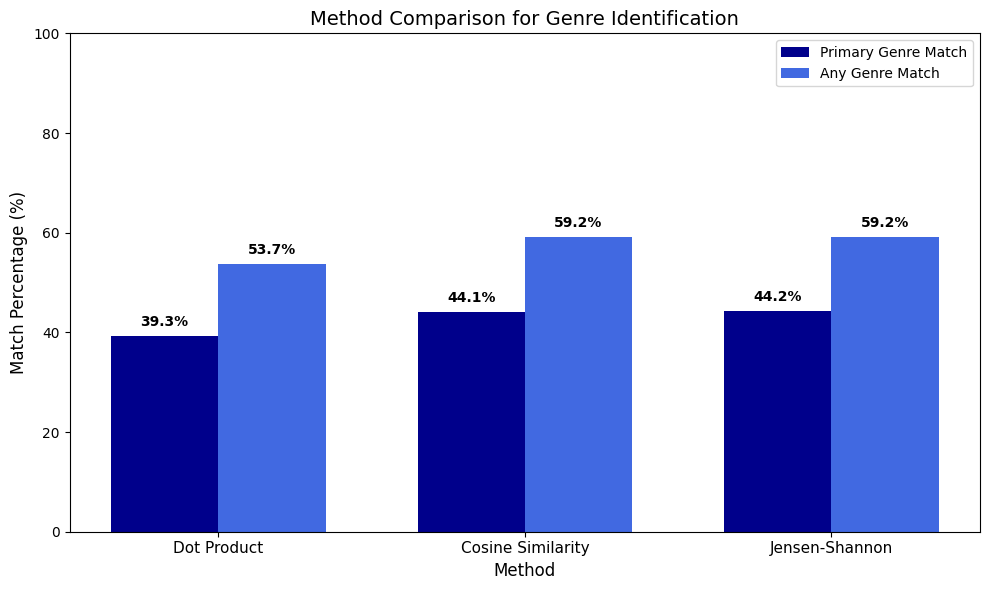

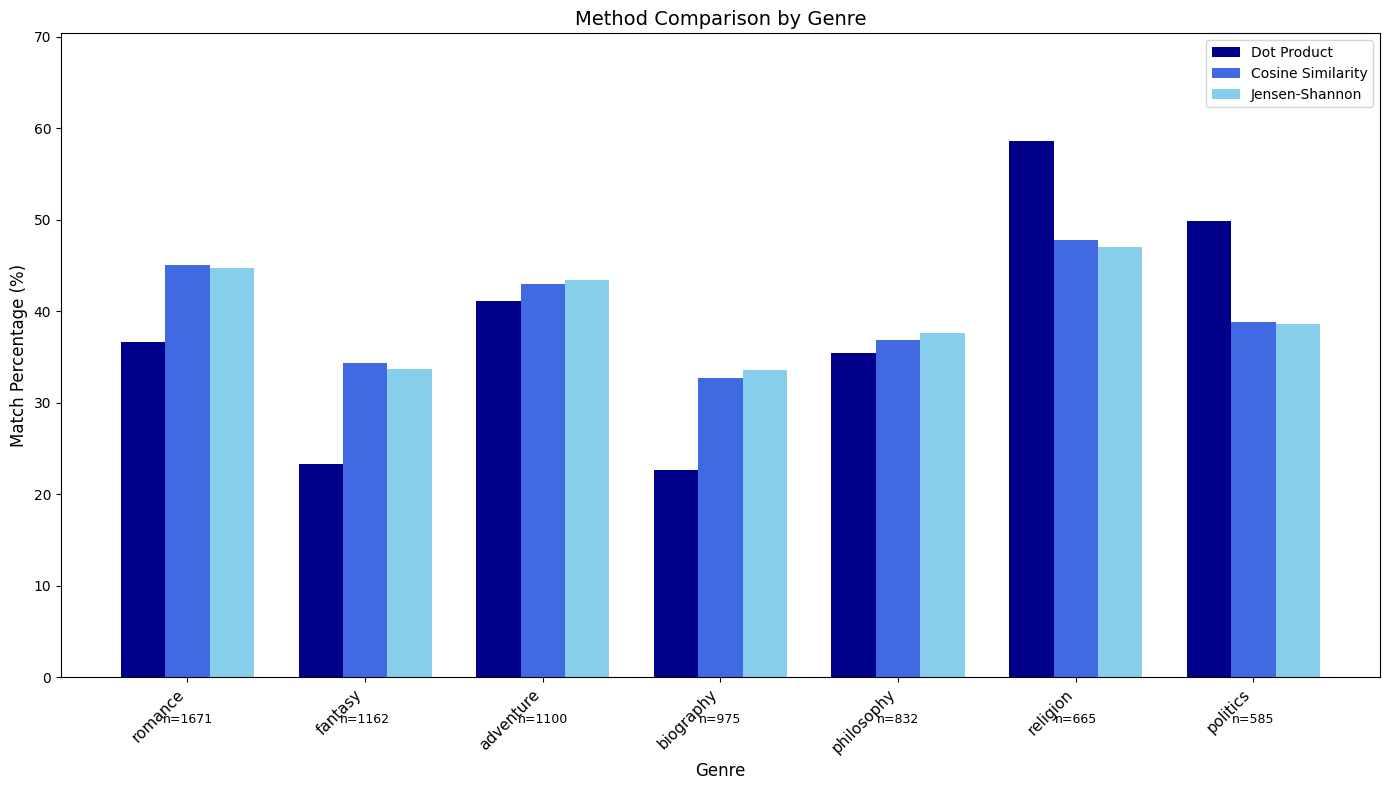

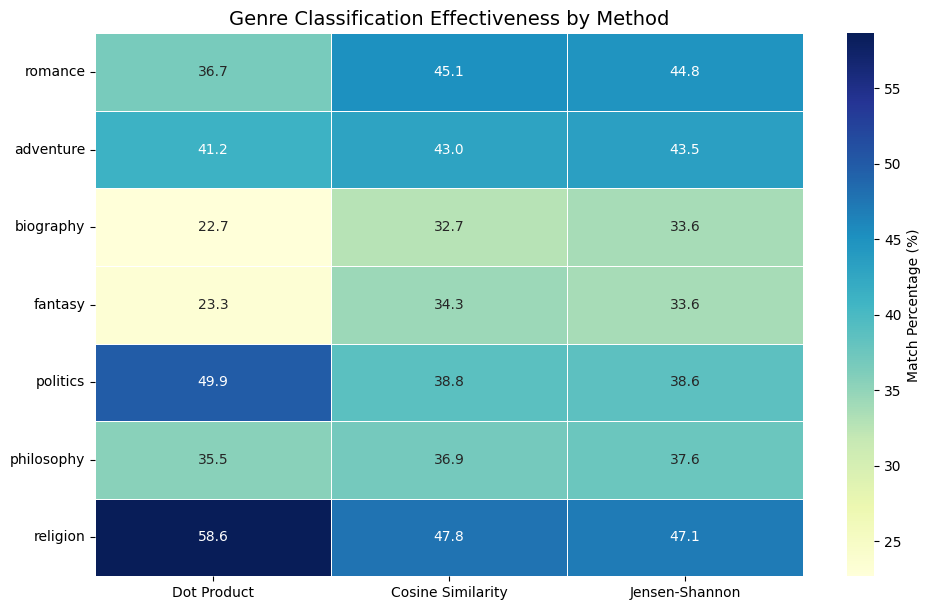

In [9]:
# 1. Overall method comparison
print("Creating overall method comparison chart...")
plt.figure(figsize=(10, 6))

# Data for the grouped bar chart
methods = ["Dot Product", "Cosine Similarity", "Jensen-Shannon"]
primary_match = [
    dot_overall['primary_match_pct'],
    cosine_overall['primary_match_pct'],
    js_overall['primary_match_pct']
]
any_match = [
    dot_overall['any_match_pct'],
    cosine_overall['any_match_pct'], 
    js_overall['any_match_pct']
]

# Set position of bars on X axis
x = np.arange(len(methods))
width = 0.35

# Create bars
bars1 = plt.bar(x - width/2, primary_match, width, label='Primary Genre Match', color='darkblue')
bars2 = plt.bar(x + width/2, any_match, width, label='Any Genre Match', color='royalblue')

# Add labels and title
plt.title("Method Comparison for Genre Identification", fontsize=14)
plt.ylabel("Match Percentage (%)", fontsize=12)
plt.xlabel("Method", fontsize=12)
plt.xticks(x, methods, fontsize=11)
plt.ylim(0, 100)

# Add value labels
def add_labels(bars, values):
    for bar, value in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            value + 2, 
            f"{value:.1f}%", 
            ha='center', 
            fontsize=10, 
            fontweight='bold'
        )

add_labels(bars1, primary_match)
add_labels(bars2, any_match)

# Add legend
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('imgs/method_comparison_overall.png', dpi=300)
print("  Saved method_comparison_overall.png")

# 2. Per-genre method comparison
print("Creating per-genre method comparison chart...")

# Get common genres with stats from all methods
common_genres = [g for g in desired_genres if g in dot_genre_stats and g in cosine_genre_stats and g in js_genre_stats]

if common_genres:
    plt.figure(figsize=(14, 8))
    
    # Prepare data
    genre_data = []
    for genre in common_genres:
        genre_data.append({
            'genre': genre,
            'dot': dot_genre_stats[genre]['effectiveness'],
            'cosine': cosine_genre_stats[genre]['effectiveness'],
            'js': js_genre_stats[genre]['effectiveness'],
            'count': dot_genre_stats[genre]['total']
        })
    
    # Sort by count (descending)
    genre_data = sorted(genre_data, key=lambda x: x['count'], reverse=True)
    
    # Extract data for plotting
    genres = [item['genre'] for item in genre_data]
    dot_scores = [item['dot'] for item in genre_data]
    cosine_scores = [item['cosine'] for item in genre_data]
    js_scores = [item['js'] for item in genre_data]
    counts = [item['count'] for item in genre_data]
    
    # Set bar positions
    x = np.arange(len(genres))
    width = 0.25
    
    # Create grouped bars
    plt.bar(x - width, dot_scores, width, label='Dot Product', color='darkblue')
    plt.bar(x, cosine_scores, width, label='Cosine Similarity', color='royalblue')
    plt.bar(x + width, js_scores, width, label='Jensen-Shannon', color='skyblue')
    
    # Add book counts beneath each genre
    for i, count in enumerate(counts):
        plt.text(
            i, 
            -5,  # Position below the x-axis
            f"n={count}", 
            ha='center', 
            fontsize=9
        )
    
    # Add labels and formatting
    plt.title("Method Comparison by Genre", fontsize=14)
    plt.ylabel("Match Percentage (%)", fontsize=12)
    plt.xlabel("Genre", fontsize=12)
    plt.xticks(x, genres, rotation=45, ha='right', fontsize=11)
    plt.ylim(0, max(max(dot_scores), max(cosine_scores), max(js_scores)) * 1.2)  # Add headroom
    
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('imgs/method_comparison_by_genre.png', dpi=300)
    print("  Saved method_comparison_by_genre.png")
else:
    print("Warning: Not enough common genres for comparison chart")

# 3. Heatmap of best methods per genre
print("Creating best method heatmap...")

# Prepare data for heatmap
method_names = ["Dot Product", "Cosine Similarity", "Jensen-Shannon"]
heatmap_data = np.zeros((len(common_genres), len(method_names)))

for i, genre in enumerate(common_genres):
    heatmap_data[i, 0] = dot_genre_stats[genre]['effectiveness']
    heatmap_data[i, 1] = cosine_genre_stats[genre]['effectiveness']
    heatmap_data[i, 2] = js_genre_stats[genre]['effectiveness']

plt.figure(figsize=(10, len(common_genres)*0.6 + 2))

# Create heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    xticklabels=method_names,
    yticklabels=common_genres,
    linewidths=0.5,
    cbar_kws={"label": "Match Percentage (%)"}
)

plt.title("Genre Classification Effectiveness by Method", fontsize=14)
plt.tight_layout()
plt.savefig('imgs/method_effectiveness_heatmap.png', dpi=300)
print("  Saved method_effectiveness_heatmap.png")


Analyzing these genres: ['romance', 'adventure', 'biography', 'fantasy', 'politics', 'philosophy', 'religion']
Found dictionaries for: ['romance', 'fantasy', 'adventure', 'biography', 'philosophy', 'religion', 'politics']
Using 40951 numeric columns for analysis
Calculating vocabulary distribution by genre...

----- PART 2: WITHIN-GENRE VS BETWEEN-GENRE SIMILARITY HEATMAP -----
Using 7 genres with at least 20 books each

Within-genre vs Between-genre Similarity Statistics:
Within-genre average: 0.1508
Between-genre average: 0.1372
Difference: 0.0136


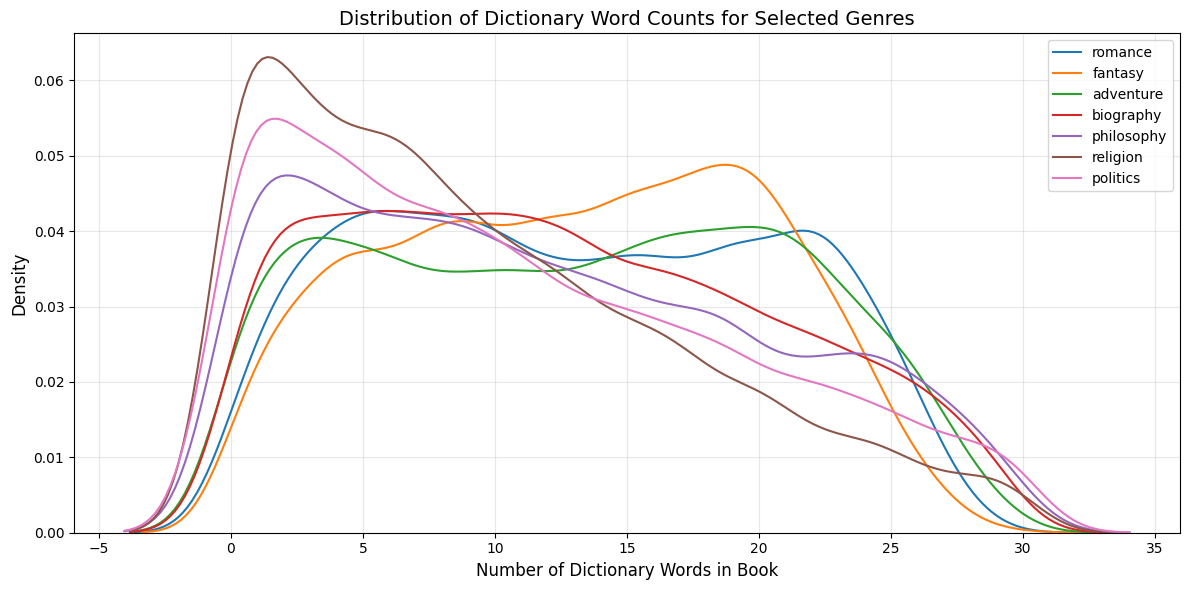

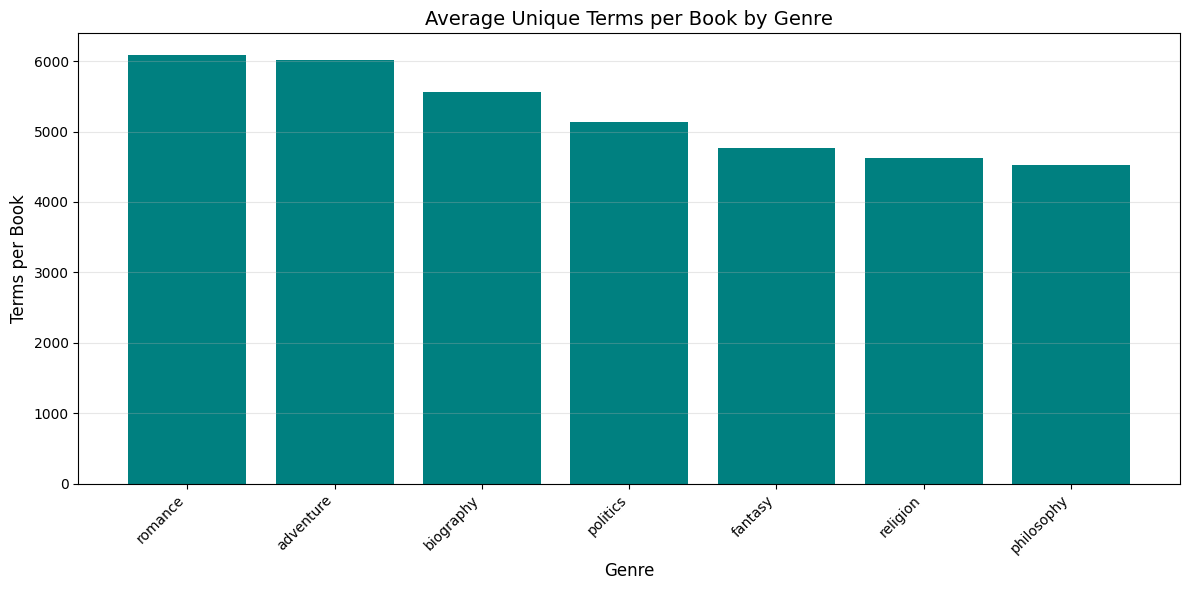

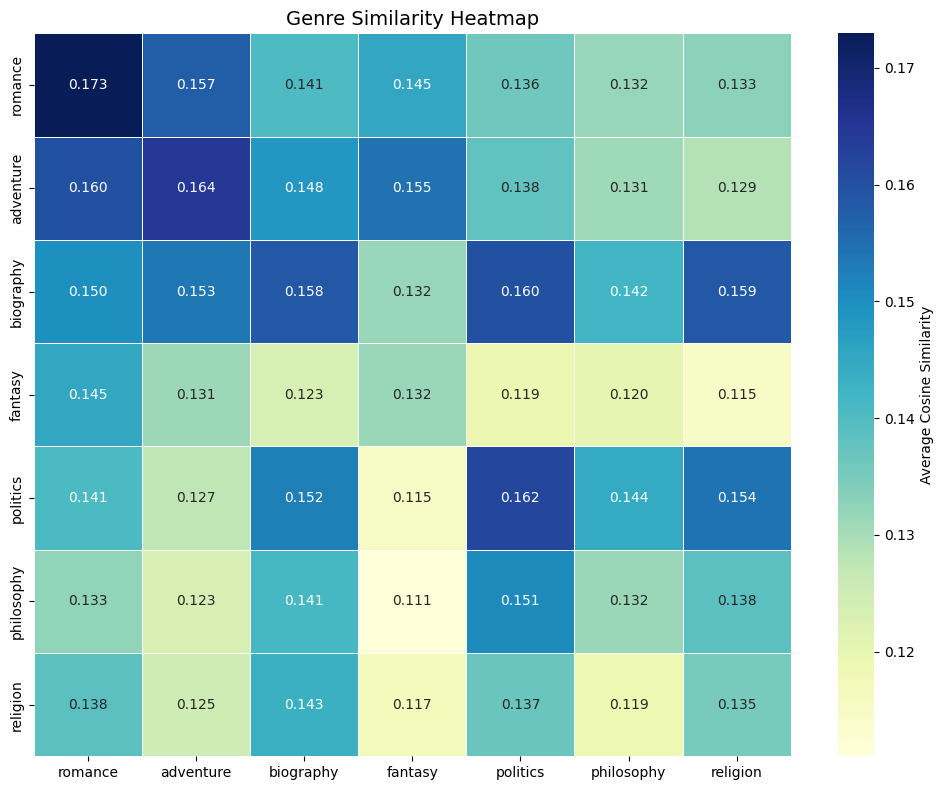

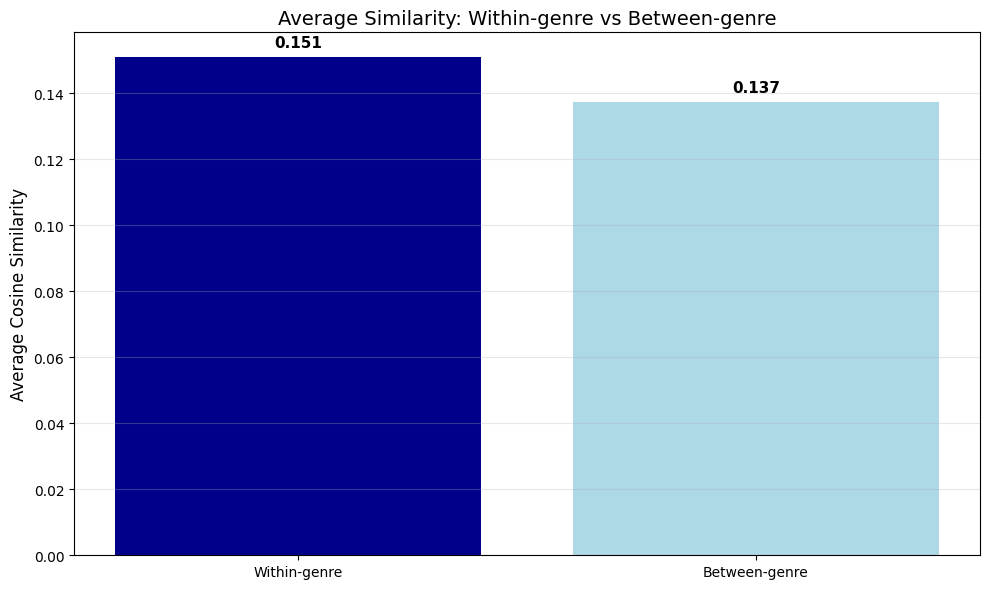

In [10]:
# Define the genres we want to analyze
desired_genres = ['romance', 'adventure', 'biography', 'fantasy', 'politics', 'philosophy', 'religion']
print(f"Analyzing these genres: {desired_genres}")

# Function to match desired genres
def match_desired_genres(book_genres, desired_genres):
    """
    Match book genres against desired genres
    
    Args:
    book_genres (list): List of genres for a book
    desired_genres (list): List of genres we want to analyze
    
    Returns:
    list: Matched genres
    """
    if not isinstance(book_genres, list):
        return []
    
    # Convert both to lowercase for case-insensitive matching
    book_genres_lower = [genre.lower() for genre in book_genres]
    desired_genres_lower = [genre.lower() for genre in desired_genres]
    
    # Find intersection of book genres and desired genres
    matched_genres = [genre for genre in book_genres_lower if genre in desired_genres_lower]
    
    return matched_genres

# Prepare DataFrame for genre analysis
def prepare_genre_analysis(df_dtm, desired_genres):
    """
    Prepare DataFrame for genre analysis with proper genre matching
    
    Args:
    df_dtm (DataFrame): Original DataFrame
    desired_genres (list): Genres to analyze
    
    Returns:
    DataFrame: Modified DataFrame with genre matching
    """
    # Create a new column with matched genres
    df_dtm['matched_genres'] = df_dtm['genres'].apply(
        lambda x: match_desired_genres(x, desired_genres)
    )
    
    # Create a column indicating if book has any matched genres
    df_dtm['has_matched_genre'] = df_dtm['matched_genres'].apply(len) > 0
    
    return df_dtm

# Robust Similarity Computation
def compute_robust_similarity(vectors1, vectors2, max_pairs=100):
    """
    Compute average cosine similarity with more robust approach
    
    Args:
    vectors1 (numpy.ndarray): First set of vectors
    vectors2 (numpy.ndarray): Second set of vectors
    max_pairs (int): Maximum number of pairs to compare
    
    Returns:
    float: Average cosine similarity
    """
    # Validate input
    if len(vectors1) == 0 or len(vectors2) == 0:
        return np.nan
    
    # Choose appropriate sampling/computation strategy
    if len(vectors1) * len(vectors2) > max_pairs:
        # Weighted random sampling
        similarities = []
        for _ in range(max_pairs):
            # Stratified sampling to reduce bias
            i = np.random.choice(len(vectors1))
            j = np.random.choice(len(vectors2))
            
            # Careful handling of potential zero vectors
            vec1 = vectors1[i]
            vec2 = vectors2[j]
            
            # Avoid division by zero and handle potential edge cases
            if np.all(vec1 == 0) or np.all(vec2 == 0):
                continue
            
            # Compute cosine similarity with more robust method
            sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
            similarities.append(sim)
    else:
        # Full pairwise computation for smaller sets
        similarities = []
        for vec1 in vectors1:
            for vec2 in vectors2:
                # Avoid division by zero
                if np.all(vec1 == 0) or np.all(vec2 == 0):
                    continue
                
                # Compute cosine similarity
                sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
                similarities.append(sim)
    
    # Return average, handling potential empty list
    return np.mean(similarities) if similarities else np.nan

# --------------------------------------------------------------------------------------
# PART 1: Distribution of vocabulary terms over the corpus
# --------------------------------------------------------------------------------------
# Filter to only include dictionaries for desired genres
filtered_dict = {genre: words for genre, words in genre_dict.items() if genre in desired_genres}
print(f"Found dictionaries for: {list(filtered_dict.keys())}")

# Plot the distribution of dictionary words in books
plt.figure(figsize=(12, 6))
for genre, word_dict in filtered_dict.items():
    # Get dictionary words that appear in our corpus
    dict_words = [word for word in word_dict.keys() if word in df_dtm.columns]
    
    if dict_words:
        # Count how many of these words appear in each book
        word_counts = (df_dtm[dict_words] > 0).sum(axis=1)
        # Plot the distribution
        sns.kdeplot(word_counts, label=genre)

plt.title("Distribution of Dictionary Word Counts for Selected Genres", fontsize=14)
plt.xlabel("Number of Dictionary Words in Book", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('imgs/desired_genres_dictionary_counts.png', dpi=300)

# Get numeric word columns for analysis
word_cols = [col for col in df_dtm.columns if col != 'genres' and 
             not col.endswith('_count') and not col.endswith('_similarity') and
             not col.endswith('_dict') and not col.endswith('_dot') and
             not col.endswith('_js') and not col.endswith('_cosine')]
numeric_cols = [col for col in word_cols if pd.api.types.is_numeric_dtype(df_dtm[col])]
print(f"Using {len(numeric_cols)} numeric columns for analysis")

# Prepare DataFrame with genre matching
df_matched = prepare_genre_analysis(df_dtm.copy(), desired_genres)

# Calculate vocabulary distribution by genre
print("Calculating vocabulary distribution by genre...")
genre_term_counts = {}
genre_book_counts = {}

for genre in desired_genres:
    # Get books with matched genre
    books = df_matched[
        df_matched['matched_genres'].apply(
            lambda x: genre.lower() in [g.lower() for g in x]
        )
    ]
    
    if len(books) == 0:
        continue
    
    # Count books and terms in this genre
    genre_book_counts[genre] = len(books)
    term_count = (books[numeric_cols] > 0).sum().sum()
    genre_term_counts[genre] = term_count

# Calculate terms per book for normalization
terms_per_book = {genre: counts / genre_book_counts[genre] 
                 for genre, counts in genre_term_counts.items()}

# Plot vocabulary distribution by genre
plt.figure(figsize=(12, 6))
genres = list(terms_per_book.keys())
values = list(terms_per_book.values())

# Sort by values (descending)
sorted_indices = np.argsort(values)[::-1]
sorted_genres = [genres[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]

plt.bar(sorted_genres, sorted_values, color='teal')
plt.title('Average Unique Terms per Book by Genre', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Terms per Book', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('imgs/terms_per_book_by_genre.png', dpi=300)

# --------------------------------------------------------------------------------------
# PART 2: Within-genre vs Between-genre Similarity Heatmap
# --------------------------------------------------------------------------------------
print("\n----- PART 2: WITHIN-GENRE VS BETWEEN-GENRE SIMILARITY HEATMAP -----")

# Filter to only include genres with sufficient books
min_books = 20
valid_genres = [genre for genre, count in genre_book_counts.items() if count >= min_books]
print(f"Using {len(valid_genres)} genres with at least {min_books} books each")

# Prepare vectors and similarity matrix
n = len(valid_genres)
similarity_matrix = np.zeros((n, n))
genre_vectors = {}

for genre in valid_genres:
    # Get books with matched genre
    books = df_matched[
        df_matched['matched_genres'].apply(
            lambda x: genre.lower() in [g.lower() for g in x]
        )
    ]
    genre_vectors[genre] = books[numeric_cols].values

# Compute pairwise similarities
for i, genre1 in enumerate(valid_genres):
    for j, genre2 in enumerate(valid_genres):
        vectors1 = genre_vectors[genre1]
        vectors2 = genre_vectors[genre2]
        
        if i == j:  # Within-genre
            similarity_matrix[i, j] = compute_robust_similarity(vectors1, vectors1)
        else:  # Between-genre
            similarity_matrix[i, j] = compute_robust_similarity(vectors1, vectors2)

# Create heatmap
similarity_df = pd.DataFrame(similarity_matrix, index=valid_genres, columns=valid_genres)
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap='YlGnBu', fmt='.3f', 
           linewidths=0.5, cbar_kws={"label": "Average Cosine Similarity"})
plt.title('Genre Similarity Heatmap', fontsize=14)
plt.tight_layout()
plt.savefig('imgs/genre_similarity_heatmap.png', dpi=300)

# Calculate overall within-genre vs between-genre statistics
within_genre_similarities = np.diagonal(similarity_matrix)
mask = ~np.eye(n, dtype=bool)
between_genre_similarities = similarity_matrix[mask]

print("\nWithin-genre vs Between-genre Similarity Statistics:")
print(f"Within-genre average: {np.mean(within_genre_similarities):.4f}")
print(f"Between-genre average: {np.mean(between_genre_similarities):.4f}")
print(f"Difference: {np.mean(within_genre_similarities) - np.mean(between_genre_similarities):.4f}")

# Plot comparison bar chart
plt.figure(figsize=(10, 6))
labels = ['Within-genre', 'Between-genre']
values = [np.mean(within_genre_similarities), np.mean(between_genre_similarities)]
bars = plt.bar(labels, values, color=['darkblue', 'lightblue'])
plt.title('Average Similarity: Within-genre vs Between-genre', fontsize=14)
plt.ylabel('Average Cosine Similarity', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add values on top of bars
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        value + 0.003, 
        f"{value:.3f}", 
        ha='center', 
        fontsize=11, 
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('imgs/within_between_comparison.png', dpi=300)

### END OF FILE ###